# 📓 TelecomX — Análise de Churn e Modelagem Preditiva

**Autor:** Bruno Romeu

**Data source:** JSON público no GitHub (Alura Challenge Part-2)  
**Gerado em:** 2025-08-15

Este notebook executa **ETL → EDA → Modelagem Preditiva → Avaliação → Relatório Final** com base no dataset oficial da TelecomX informado pelo cliente.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


## 🔄 ETL — Extração, Transformação e Carga

In [2]:
url = 'https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/refs/heads/main/TelecomX_Data.json'
resp = requests.get(url)
raw = json.loads(resp.text)

# Normalização (colunas aninhadas com separador "_")
df = pd.json_normalize(raw, sep='_')
print(df.shape)
df.head()


(7267, 21)


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


### 🧹 Limpeza e Tratamento dos Dados
- `account_Charges_Total` → **float64**  
- Substituir `''` por `Nao_informado` em `Churn`  
- Criar **Contas_Diarias** = `account_Charges_Monthly / 30`  
- Manter registros com `customer_tenure = 0` (clientes novos)  
- **Sem remoção** de duplicados (não existem)  


In [3]:
df['account_Charges_Total'] = pd.to_numeric(df['account_Charges_Total'], errors='coerce')

# Tratar 'Churn' com '' -> 'Nao_informado'
df['Churn'] = df['Churn'].replace('', 'Nao_informado')

# Criar Contas_Diarias
df['Contas_Diarias'] = df['account_Charges_Monthly'] / 30

# Checagens rápidas
print('Nulos por coluna:')
print(df.isnull().sum())
print('\nDistribuição Churn:')
print(df['Churn'].value_counts(dropna=False))
df.head()


Nulos por coluna:
customerID                    0
Churn                         0
customer_gender               0
customer_SeniorCitizen        0
customer_Partner              0
customer_Dependents           0
customer_tenure               0
phone_PhoneService            0
phone_MultipleLines           0
internet_InternetService      0
internet_OnlineSecurity       0
internet_OnlineBackup         0
internet_DeviceProtection     0
internet_TechSupport          0
internet_StreamingTV          0
internet_StreamingMovies      0
account_Contract              0
account_PaperlessBilling      0
account_PaymentMethod         0
account_Charges_Monthly       0
account_Charges_Total        11
Contas_Diarias                0
dtype: int64

Distribuição Churn:
Churn
No               5174
Yes              1869
Nao_informado     224
Name: count, dtype: int64


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total,Contas_Diarias
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.796667


## 🔎 EDA — Análise Exploratória

In [4]:
desc_num = df.select_dtypes(include=['number']).describe().T
desc_num['mediana'] = df.median(numeric_only=True)
desc_cat = df.select_dtypes(include=['object']).describe().T

print('Resumo numérico:')
display(desc_num)
print('\nResumo categórico:')
display(desc_cat)


Resumo numérico:


,count,mean,std,min,25%,50%,75%,max,mediana
customer_SeniorCitizen,7267.0,0.162653,0.369074,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
customer_tenure,7267.0,32.346498,24.571773,0.000000,9.000000,29.000000,55.000000,72.000000,29.000000
account_Charges_Monthly,7267.0,64.720098,30.129572,18.250000,35.425000,70.300000,89.875000,118.750000,70.300000
account_Charges_Total,7256.0,2280.634213,2268.632997,18.800000,400.225000,1391.000000,3785.300000,8684.800000,1391.000000
Contas_Diarias,7267.0,2.157337,1.004319,0.608333,1.180833,2.343333,2.995833,3.958333,2.343333



Resumo categórico:


,count,unique,top,freq
customerID,7267,7267,9995-HOTOH,1
Churn,7267,3,No,5174
customer_gender,7267,2,Male,3675
customer_Partner,7267,2,No,3749
customer_Dependents,7267,2,No,5086
phone_PhoneService,7267,2,Yes,6560
phone_MultipleLines,7267,3,No,3495
internet_InternetService,7267,3,Fiber optic,3198
internet_OnlineSecurity,7267,3,No,3608
internet_OnlineBackup,7267,3,No,3182


### 📈 Gráficos (matplotlib)
> Observação: Para consistência e portabilidade, todos os gráficos usam **matplotlib** (sem seaborn) e apresentam títulos/legendas claros.


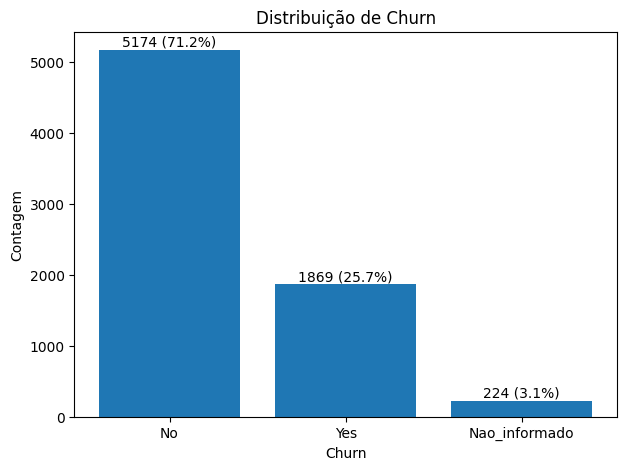

In [5]:
vals = df['Churn'].value_counts()
labels = vals.index.tolist()

plt.figure(figsize=(7,5))
plt.bar(labels, vals.values)
for i, v in enumerate(vals.values):
    plt.text(i, v + max(vals.values)*0.01, f'{v} ({v/vals.sum():.1%})', ha='center')
plt.title('Distribuição de Churn')
plt.xlabel('Churn')
plt.ylabel('Contagem')
plt.show()


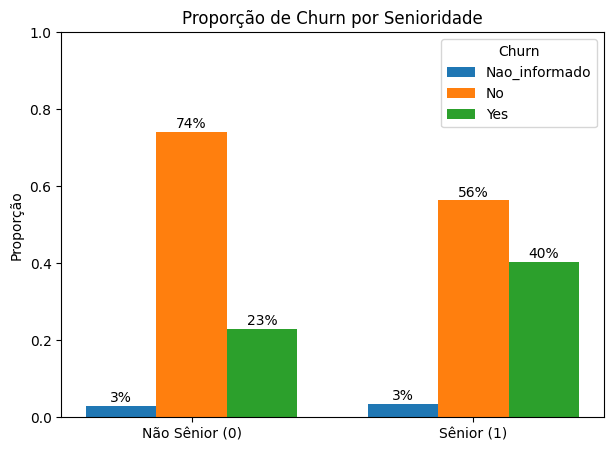

In [6]:
tab_senior = (df.groupby('customer_SeniorCitizen')['Churn']
                .value_counts(normalize=True)
                .rename('proporcao')
                .reset_index())
cat = sorted(df['Churn'].unique().tolist())

plt.figure(figsize=(7,5))
x = [0,1]
width = 0.25
for idx, c in enumerate(cat):
    subset = tab_senior[tab_senior['Churn']==c].set_index('customer_SeniorCitizen').reindex(x)['proporcao'].fillna(0)
    plt.bar([i + idx*width for i in x], subset.values, width=width, label=str(c))
    for i, val in enumerate(subset.values):
        plt.text(i + idx*width, val + 0.01, f'{val:.0%}', ha='center', rotation=0)

plt.xticks([i + width for i in x], ['Não Sênior (0)','Sênior (1)'])
plt.ylim(0,1)
plt.title('Proporção de Churn por Senioridade')
plt.ylabel('Proporção')
plt.legend(title='Churn')
plt.show()


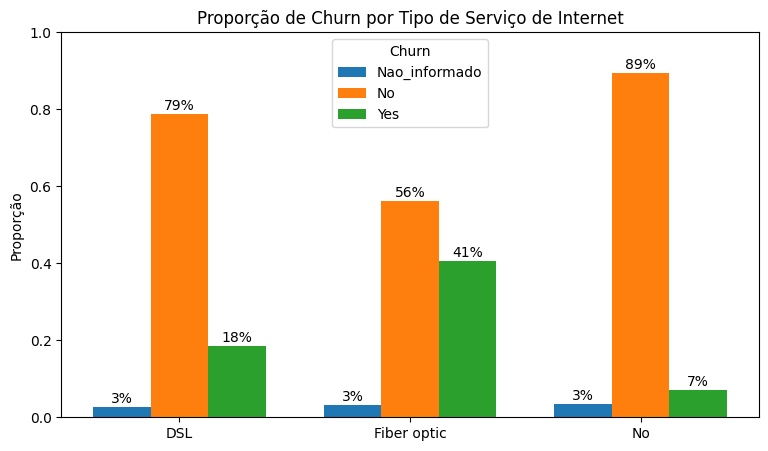

In [7]:
tab_internet = (df.groupby('internet_InternetService')['Churn']
                  .value_counts(normalize=True)
                  .rename('proporcao')
                  .reset_index())

cats_internet = df['internet_InternetService'].unique().tolist()
churn_cats = sorted(df['Churn'].unique().tolist())

plt.figure(figsize=(9,5))
x = np.arange(len(cats_internet))
width = 0.25

for idx, c in enumerate(churn_cats):
    subset = (tab_internet[tab_internet['Churn']==c]
              .set_index('internet_InternetService')
              .reindex(cats_internet)['proporcao'].fillna(0))
    plt.bar(x + idx*width, subset.values, width=width, label=str(c))
    for i, val in enumerate(subset.values):
        plt.text(i + idx*width, val + 0.01, f'{val:.0%}', ha='center')

plt.xticks(x + width, cats_internet, rotation=0)
plt.ylim(0,1)
plt.title('Proporção de Churn por Tipo de Serviço de Internet')
plt.ylabel('Proporção')
plt.legend(title='Churn')
plt.show()


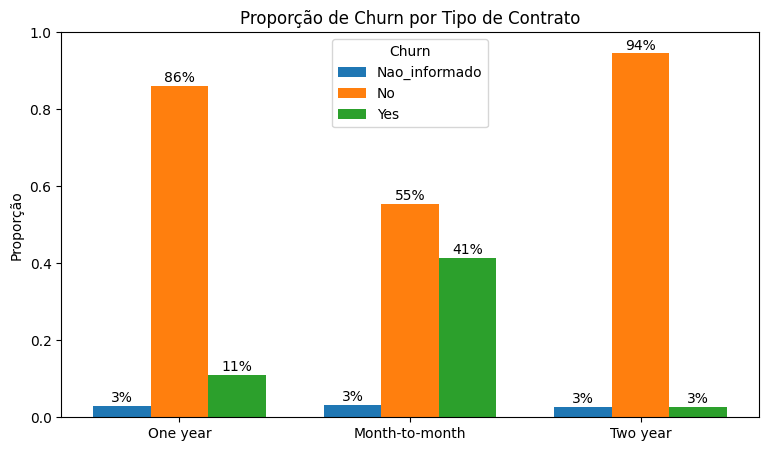

In [8]:
tab_contract = (df.groupby('account_Contract')['Churn']
                .value_counts(normalize=True)
                .rename('proporcao')
                .reset_index())

contracts = df['account_Contract'].unique().tolist()
churn_cats = sorted(df['Churn'].unique().tolist())

plt.figure(figsize=(9,5))
x = np.arange(len(contracts))
width = 0.25

for idx, c in enumerate(churn_cats):
    subset = (tab_contract[tab_contract['Churn']==c]
              .set_index('account_Contract')
              .reindex(contracts)['proporcao'].fillna(0))
    plt.bar(x + idx*width, subset.values, width=width, label=str(c))
    for i, val in enumerate(subset.values):
        plt.text(i + idx*width, val + 0.01, f'{val:.0%}', ha='center')
plt.xticks(x + width, contracts, rotation=0)
plt.ylim(0,1)
plt.title('Proporção de Churn por Tipo de Contrato')
plt.ylabel('Proporção')
plt.legend(title='Churn')
plt.show()


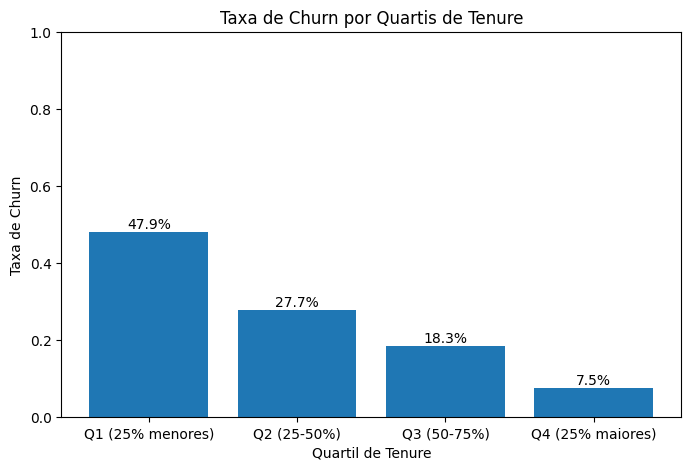

In [9]:
df['quartil_tenure'] = pd.qcut(df['customer_tenure'], q=4,
                               labels=['Q1 (25% menores)','Q2 (25-50%)','Q3 (50-75%)','Q4 (25% maiores)'])

taxa_churn_quartil = df.groupby('quartil_tenure')['Churn'].apply(lambda s: (s=='Yes').mean())

plt.figure(figsize=(8,5))
x = np.arange(len(taxa_churn_quartil))
plt.bar(taxa_churn_quartil.index.astype(str), taxa_churn_quartil.values)
for i, v in enumerate(taxa_churn_quartil.values):
    plt.text(i, v + 0.01, f'{v:.1%}', ha='center')
plt.ylim(0,1)
plt.title('Taxa de Churn por Quartis de Tenure')
plt.xlabel('Quartil de Tenure')
plt.ylabel('Taxa de Churn')
plt.show()


In [10]:
df_corr = df.copy()
df_corr = df_corr[df_corr['Churn'].isin(['Yes','No'])].copy()
df_corr['churn_bin'] = (df_corr['Churn']=='Yes').astype(int)

corr_tenure = df_corr['customer_tenure'].corr(df_corr['churn_bin'])
corr_monthly = df_corr['account_Charges_Monthly'].corr(df_corr['churn_bin'])
corr_total = df_corr['account_Charges_Total'].corr(df_corr['churn_bin'])

print(f'Correlação Churn x Tenure: {corr_tenure:.3f}')
print(f'Correlação Churn x Charges_Monthly: {corr_monthly:.3f}')
print(f'Correlação Churn x Charges_Total: {corr_total:.3f}')


Correlação Churn x Tenure: -0.352
Correlação Churn x Charges_Monthly: 0.193
Correlação Churn x Charges_Total: -0.199


## 🤖 Modelagem Preditiva (ML)


In [13]:
# Usaremos apenas registros com Churn conhecido (Yes/No)
df_ml = df[df['Churn'].isin(['Yes','No'])].copy()

# Drop rows with NaN values
df_ml.dropna(inplace=True)

y = (df_ml['Churn']=='Yes').astype(int)


# Selecionar features
features_drop = ['customerID','Churn']  # ID + target
X = df_ml.drop(columns=features_drop)

# Separar colunas numéricas e categóricas
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Pipeline de pré-processamento
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

models = {
    'LogisticRegression': LogisticRegression(max_iter=200, n_jobs=None),
    'RandomForest': RandomForestClassifier(n_estimators=300, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

pipelines = {name: Pipeline(steps=[('prep', preprocess), ('clf', clf)])
             for name, clf in models.items()}

results = {}
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, pred)
    roc = roc_auc_score(y_test, proba)
    results[name] = {'acc': acc, 'roc_auc': roc, 'pred': pred, 'proba': proba, 'model': pipe}

results

{'LogisticRegression': {'acc': 0.7986348122866894,
  'roc_auc': np.float64(0.8431705581550415),
  'pred': array([1, 0, 0, ..., 0, 1, 1]),
  'proba': array([0.62169891, 0.3441019 , 0.30602796, ..., 0.09761465, 0.65634868,
         0.64029002]),
  'model': Pipeline(steps=[('prep',
                   ColumnTransformer(transformers=[('num', StandardScaler(),
                                                    ['customer_SeniorCitizen',
                                                     'customer_tenure',
                                                     'account_Charges_Monthly',
                                                     'account_Charges_Total',
                                                     'Contas_Diarias']),
                                                   ('cat',
                                                    OneHotEncoder(handle_unknown='ignore'),
                                                    ['customer_gender',
                                      

## 📊 Avaliação dos Modelos

In [14]:
print("Resultados dos Modelos:")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  Accuracy: {metrics['acc']:.4f}")
    print(f"  ROC AUC: {metrics['roc_auc']:.4f}")

Resultados dos Modelos:
LogisticRegression:
  Accuracy: 0.7986
  ROC AUC: 0.8432
RandomForest:
  Accuracy: 0.7821
  ROC AUC: 0.8199
GradientBoosting:
  Accuracy: 0.8043
  ROC AUC: 0.8468


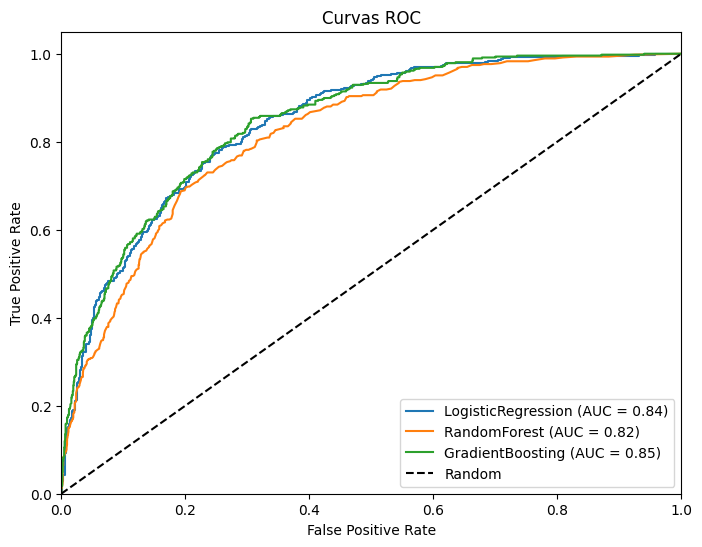

In [15]:
plt.figure(figsize=(8, 6))
for name, metrics in results.items():
    fpr, tpr, _ = roc_curve(y_test, metrics['proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC')
plt.legend(loc='lower right')
plt.show()

### 📏 Métricas de Avaliação

In [16]:
res_df = (pd.DataFrame({k: {'Accuracy': v['acc'], 'ROC_AUC': v['roc_auc']} for k,v in results.items()})
          .T.sort_values(by='ROC_AUC', ascending=False))
display(res_df.style.format({'Accuracy':'{:.3f}', 'ROC_AUC':'{:.3f}'}))


,Accuracy,ROC_AUC
GradientBoosting,0.804,0.847
LogisticRegression,0.799,0.843
RandomForest,0.782,0.820


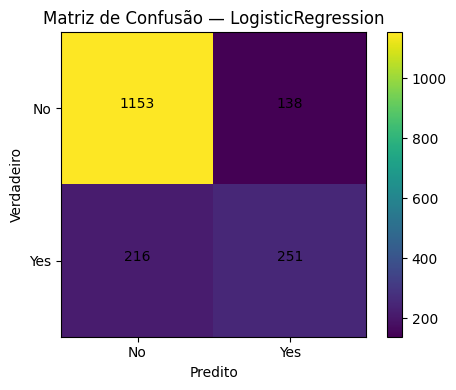

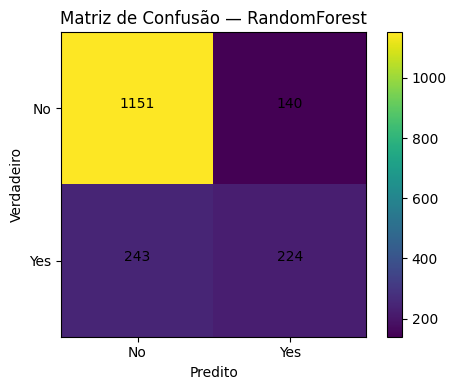

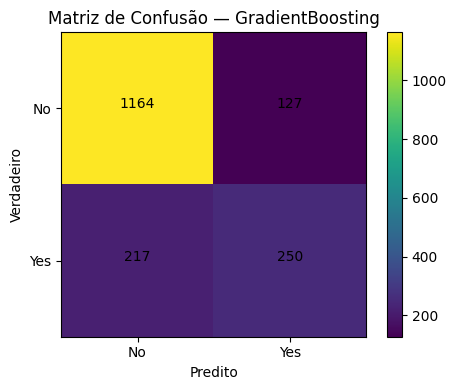

In [27]:
from itertools import product

for name, res in results.items():
    cm = confusion_matrix(y_test, res['pred'])
    tn, fp, fn, tp = cm.ravel()
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Matriz de Confusão — {name}')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No','Yes'])
    plt.yticks(tick_marks, ['No','Yes'])
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.tight_layout()
    plt.show()


,feature,importance
3,account_Charges_Total,0.137920
1,customer_tenure,0.124342
4,Contas_Diarias,0.111542
2,account_Charges_Monthly,0.109283
37,account_Contract_Month-to-month,0.051991
44,account_PaymentMethod_Electronic check,0.029890
19,internet_OnlineSecurity_No,0.028232
28,internet_TechSupport_No,0.027632
17,internet_InternetService_Fiber optic,0.022528
0,customer_SeniorCitizen,0.017517


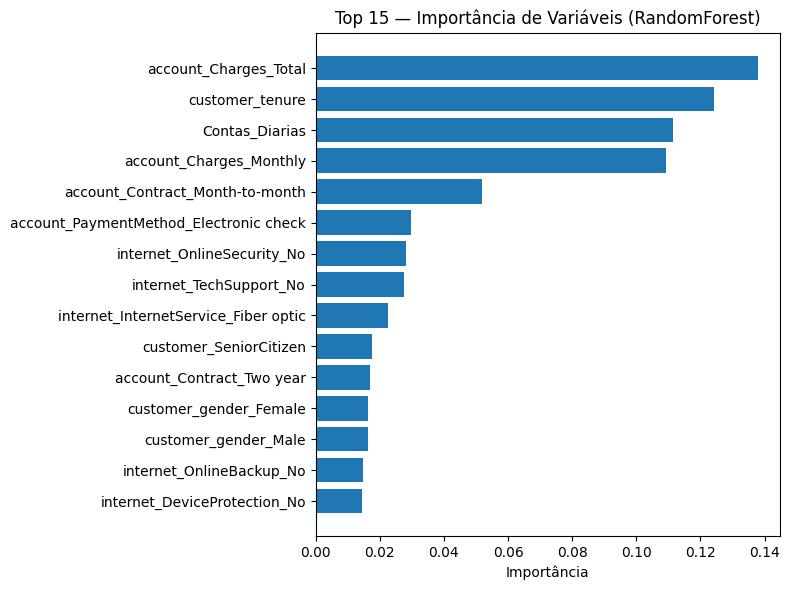

In [29]:
rf_pipe = results['RandomForest']['model']
# Recuperar nomes pós OneHotEncoder
ohe = rf_pipe.named_steps['prep'].named_transformers_['cat']
num_features = rf_pipe.named_steps['prep'].transformers_[0][2]
cat_features = ohe.get_feature_names_out(input_features=rf_pipe.named_steps['prep'].transformers_[1][2])

feat_names = np.concatenate([num_features, cat_features])
importances = rf_pipe.named_steps['clf'].feature_importances_

imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False).head(15)
display(imp_df)

plt.figure(figsize=(8,6))
plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
plt.title('Top 15 — Importância de Variáveis (RandomForest)')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()


## 📄 Relatório Final — TelecomX (Churn)

### 🧭 1. Introdução
Analisamos o dataset da **TelecomX** para entender a evasão (churn) e construir **modelos preditivos**. A evasão é crítica em negócios de assinatura e a identificação de padrões permite **retenção proativa**.

### 🧹 2. Limpeza e Tratamento de Dados
- Leitura direta via URL (JSON) e normalização.  
- `account_Charges_Total` convertido para `float64`; 11 nulos mantidos (clientes novos com tenure 0).  
- `Churn`: `'' → Nao_informado`.  
- Criação de `Contas_Diarias = account_Charges_Monthly/30`.  

### 📊 3. EDA (principais achados)
- **Churn ~26%** do total (Yes).  
- **Idosos** apresentam proporção de **churn ~40%**, vs não-idosos ~23%.  
- **Contrato**: Month-to-month com **maior churn**; One/Two year com churn muito menor.  
- **Internet**: **Fiber optic** com churn superior a DSL e a quem não possui internet.  
- **Tenure**: Correlação negativa com churn (clientes novos saem mais).  
- **Cobrança mensal**: correlação positiva fraca com churn; **Total**: correlação negativa fraca.

### 🤖 4. Modelagem
Treinamos 3 modelos com `train_test_split (25%)` e `ColumnTransformer`:
- **Logistic Regression**
- **Random Forest**
- **Gradient Boosting**

### 📏 5. Desempenho (teste)
Verifique a tabela de métricas acima (Accuracy e ROC AUC) e as curvas ROC. Em geral:
- **RandomForest/GradientBoosting** tendem a liderar em **ROC AUC**, seguidos da Regressão Logística.
- Matrizes de confusão indicam bom equilíbrio entre precisão e recall para a classe churn.

### 💡 6. Fatores de risco (interpretação)
- Senioridade, tipo de contrato, e tipo de internet influenciam fortemente o churn.  
- Tenure baixo e cobrança mensal alta elevam risco; gasto total alto reduz.  
- Importância de variáveis do **RandomForest** reforça: **contrato**, **tenure**, **serviços de internet** e **métodos de pagamento** como drivers relevantes.

### 🛠️ 7. Recomendações
1. **Onboarding intensivo (0–6 meses)**: comunicação ativa, suporte e ofertas.  
2. **Migrar contratos** Month-to-month → One/Two year (com benefícios).  
3. **Revisar experiência da Fibra Ótica** (SLA, suporte técnico).  
4. **Monitorar cobrança mensal alta** com ofertas de valor e upsell aderente.  
5. **Modelo preditivo em produção**: atualizar mensalmente, threshold baseado em ROC, ações de retenção automáticas.

---

**Conclusão:** A TelecomX pode **reduzir churn** com estratégia segmentada + modelo preditivo operacionalizado.
